# Classification task

## Guidelines

* The goal is to train a neural network that maps an input image (hand-written digit) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

# Dataset

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from sklearn import metrics,manifold
import pandas as pd
from sklearn.model_selection import train_test_split

Download the dataset:

In [2]:
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

Extracting classifier_data/MNIST/raw/train-images-idx3-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/MNIST/raw
Processing...



Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


How to get an image and the corresponding label:

SAMPLE AT INDEX 0
LABEL: 5


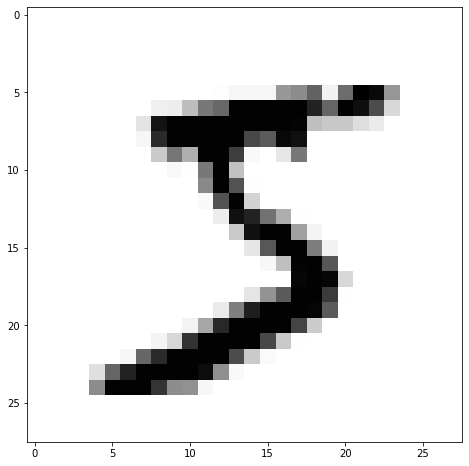

In [3]:
sample_index = 0
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]


fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

The output of the dataset is a PIL Image, a python object specifically developed to manage and process images. PyTorch supports this format, and there are useful transforms available natively in the framework: https://pytorch.org/docs/stable/torchvision/transforms.html

If you want, you can easily convert a PIL image to a numpy array and entirely ignore the PIL object:

In [4]:
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

Numpy array shape: (28, 28)
Numpy array type: uint8


To transform a PIL Image directly to a PyTorch tensor, instead:

In [5]:
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


## Transformation

In [6]:
class AddGaussianNoise(object):
    def __init__(self, mean, std):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

In [7]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    #AddGaussianNoise(0,0.2),
    #transforms.RandomRotation((-30,30))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [8]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

## Dataloader

In [9]:
# split training and validation dataset
train_dataset,val_dataset = train_test_split(train_dataset, test_size=0.20, random_state=1)

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=0)
val_dataloader   = DataLoader(val_dataset,   batch_size=len(val_dataset), shuffle=False, num_workers=0)
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)

# Initialization weight

Define different initial network weight

In [11]:
def init_weights_ones(m):
    if type(m) == nn.Linear:
        m.weight.data.fill_( 1.0)
        
#net.apply(init_weights_ones)

In [12]:
def init_weights_unif(m):
    if type(m) == nn.Linear:
        m.weight.data.uniform_(-1.0, 1.0)
#net.apply(init_weights_unif)

In [13]:
# Glorot and Bengio
def init_weights_unif_optim(m):
    if type(m) == nn.Linear:
        n_in=m.in_features
        n_out=m.out_features
        y=np.sqrt(6/(n_in+n_out))
        m.weight.data.uniform_(-y,y)
#net.apply(init_weights_unif_optim)

In [14]:
def init_weights_normal(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0,1)
#net.apply(init_weights_normal)

In [15]:
# Xavier initialization
def init_weights_normal_optim(m):
    if type(m) == nn.Linear:
        n_in=m.in_features
        x=np.sqrt(1/n_in)
        m.weight.data.normal_(0,x)
#net.apply(init_weights_normal_optim)

# Train function

In [16]:
def train_epoch(net, device, dataloader, loss_fn, optimizer):  
  train_loss= []
  net.train() # Training mode (e.g. enable dropout)
  for sample_batched in train_dataloader:
    # Move data to device
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)

    # Forward pass
    out = net(x_batch)

    # Compute loss
    loss = loss_fn(out, label_batch)

    # Backpropagation
    net.zero_grad()
    loss.backward()

    # Update the weights
    optimizer.step()

    # Save train loss for this batch
    loss_batch = loss.detach().cpu().numpy()
    train_loss.append(loss_batch)

  # Save average train loss
  train_loss = np.mean(train_loss)
  
  return train_loss

# Test function

In [17]:
def test_epoch(net, device, dataloader, loss_fn):
    net.eval() # Set evaluation mode
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, label_batch in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)

            # Forward pass
            out = net(image_batch)

            # Append the network output and the original image to the lists
            conc_out.append(out)
            conc_label.append(label_batch)

        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)

        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
        
    return conc_out, conc_label, val_loss # We return all the outputs, all the labels and the global loss

# Fully connected Neural Network

## Network definition

In [18]:
class Net(nn.Module):
    def __init__(self, act , Nh):
        
        # act: activation function
        # Nh: Hidden units

        super(Net, self).__init__()
   
        self.fc1 = nn.Linear(28 * 28, Nh)
        self.fc2 = nn.Linear(Nh, Nh)
        self.fc3 = nn.Linear(Nh, 10)

        self.dropout = nn.Dropout(0.3)
        self.act = act
        self.flatten = nn.Flatten(start_dim=1)


    def forward(self, x):

        x = self.flatten(x)
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

## Initialization

In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [20]:
# hyperparameters
activation=[nn.ReLU(), nn.SiLU(),nn.ReLU6(),nn.GELU()]
hidden_layer=[64,128,256]

# loss
loss_fn = nn.CrossEntropyLoss()


## Grid search

In [21]:
grid_search_output=[]

# grid search
for act in activation:
 for Nh in hidden_layer:

   # initialize network 
   torch.manual_seed(0)
   net = Net(act,Nh)
   net.to(device) 

   # optimizer
   optimizer = torch.optim.Adamax(net.parameters(), weight_decay=0.0005)
   
   # trainig loop
   num_epochs = 20
   for epoch_num in range(num_epochs):
     # TRAINING
     train_loss = train_epoch(net, device, train_dataloader, loss_fn, optimizer)    
     # VALIDATION
     _,_,val_loss = test_epoch(net, device, val_dataloader, loss_fn)  
    
   print('#################')
   print(f"AVERAGE TRAIN LOSS: {train_loss}")
   print(f"AVERAGE VAL LOSS: {val_loss}") 
   print(f"ACTIVATION: {(act)},   HIDDEN UNITS: {(Nh)}")  

   # list of losses and hyperparameters
   output=[train_loss,float(val_loss),act,Nh]
   # attach output
   grid_search_output.append(output)

#################
AVERAGE TRAIN LOSS: 0.15293706953525543
AVERAGE VAL LOSS: 0.10918009281158447
ACTIVATION: ReLU(),   HIDDEN UNITS: 64
#################
AVERAGE TRAIN LOSS: 0.0802900642156601
AVERAGE VAL LOSS: 0.08592639118432999
ACTIVATION: ReLU(),   HIDDEN UNITS: 128
#################
AVERAGE TRAIN LOSS: 0.04917969927191734
AVERAGE VAL LOSS: 0.07039293646812439
ACTIVATION: ReLU(),   HIDDEN UNITS: 256
#################
AVERAGE TRAIN LOSS: 0.13026633858680725
AVERAGE VAL LOSS: 0.10160914808511734
ACTIVATION: SiLU(),   HIDDEN UNITS: 64
#################
AVERAGE TRAIN LOSS: 0.08560318499803543
AVERAGE VAL LOSS: 0.08597204834222794
ACTIVATION: SiLU(),   HIDDEN UNITS: 128
#################
AVERAGE TRAIN LOSS: 0.07165779918432236
AVERAGE VAL LOSS: 0.08104592561721802
ACTIVATION: SiLU(),   HIDDEN UNITS: 256
#################
AVERAGE TRAIN LOSS: 0.15427538752555847
AVERAGE VAL LOSS: 0.10835697501897812
ACTIVATION: ReLU6(),   HIDDEN UNITS: 64
#################
AVERAGE TRAIN LOSS: 0.07958567887

### Grid search results

In [22]:
table=pd.DataFrame(data=grid_search_output, columns=['Training loss','Validation loss', 'Activation', 'Hidden units'])
table.sort_values(by=['Validation loss'])


,Training loss,Validation loss,Activation,Hidden units
8,0.048583,0.069595,ReLU6(),256
2,0.049180,0.070393,ReLU(),256
11,0.055276,0.072086,GELU(),256
10,0.074270,0.078920,GELU(),128
5,0.071658,0.081046,SiLU(),256
7,0.079586,0.084974,ReLU6(),128
1,0.080290,0.085926,ReLU(),128
4,0.085603,0.085972,SiLU(),128
9,0.128399,0.099936,GELU(),64
3,0.130266,0.101609,SiLU(),64


## Best model

In [23]:
# network 
torch.manual_seed(0)
net = Net(nn.ReLU6(),256)
net.to(device) 

# optimizer
optimizer = torch.optim.Adamax(net.parameters(), weight_decay=0.0005)

### Save initial weight

In [24]:
# First hidden layer
initial_h1_w = net.fc1.weight.data.cpu().numpy()
initial_h1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
initial_h2_w = net.fc2.weight.data.cpu().numpy()
initial_h2_b = net.fc2.bias.data.cpu().numpy()

# Output layer
initial_out_w = net.fc3.weight.data.cpu().numpy()
initial_out_b = net.fc3.bias.data.cpu().numpy()

### Training loop

In [25]:
num_epochs = 30
train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
  ### TRAINING
  print('#################')
  print(f'# EPOCH {epoch_num}')
  print('#################')
  train_loss = train_epoch(net, device, train_dataloader, loss_fn, optimizer)  
  print(f"AVERAGE TRAIN LOSS: {train_loss}")
  train_loss_log.append(train_loss)
  
  ### VALIDATION
  _,_,val_loss = test_epoch(net, device, val_dataloader, loss_fn)  
  print(f"AVERAGE VAL LOSS: {(val_loss)}")
  val_loss_log.append(val_loss)
    

#################
# EPOCH 0
#################
AVERAGE TRAIN LOSS: 0.38840606808662415
AVERAGE VAL LOSS: 0.19203799962997437
#################
# EPOCH 1
#################
AVERAGE TRAIN LOSS: 0.18790178000926971
AVERAGE VAL LOSS: 0.13412527740001678
#################
# EPOCH 2
#################
AVERAGE TRAIN LOSS: 0.1411477029323578
AVERAGE VAL LOSS: 0.1239851713180542
#################
# EPOCH 3
#################
AVERAGE TRAIN LOSS: 0.11857535690069199
AVERAGE VAL LOSS: 0.10085402429103851
#################
# EPOCH 4
#################
AVERAGE TRAIN LOSS: 0.10413637012243271
AVERAGE VAL LOSS: 0.09367445856332779
#################
# EPOCH 5
#################
AVERAGE TRAIN LOSS: 0.09060262143611908
AVERAGE VAL LOSS: 0.08646084368228912
#################
# EPOCH 6
#################
AVERAGE TRAIN LOSS: 0.08444765210151672
AVERAGE VAL LOSS: 0.09030639380216599
#################
# EPOCH 7
#################
AVERAGE TRAIN LOSS: 0.0773322731256485
AVERAGE VAL LOSS: 0.08334681391716003
###########

## Network analysis

### Plot losses

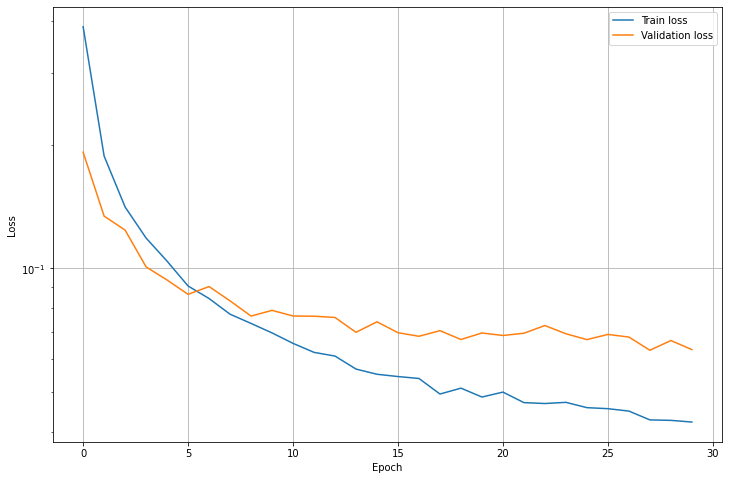

In [26]:
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Result analysis

### Test loss

In [27]:
test_outputs, test_labels, test_loss = test_epoch(
    net=net,
    device=device, 
    dataloader=test_dataloader, 
    loss_fn=loss_fn)
# Print Test loss
print(f"\nTEST LOSS : {test_loss}")


TEST LOSS : 0.05854007601737976


### Confusion matrix

In [28]:
# Predicted labels
y_true = test_labels.cpu().data.numpy()
y_pred = test_outputs.cpu().argmax(dim=1).numpy()
# Evaluate confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)
# Show the confusion matrix
pd.DataFrame(cm)

,0,1,2,3,4,5,6,7,8,9
0,972,1,1,0,0,1,3,1,1,0
1,0,1123,3,2,0,0,3,1,3,0
2,3,0,1008,5,3,0,3,6,4,0
3,0,0,3,996,0,3,0,3,1,4
4,0,0,1,1,962,0,5,2,2,9
5,2,0,0,8,1,874,2,1,3,1
6,4,2,0,1,3,2,945,0,1,0
7,3,5,8,3,1,0,0,1000,1,7
8,4,1,2,7,3,0,2,6,945,4
9,3,2,0,6,6,1,0,5,0,986


### Accuracy

In [29]:
accuracy=100*sum(np.diag(cm))/len(y_true)
print("TEST ACCURACY: ",accuracy,"%")

TEST ACCURACY:  98.11 %


### Histogram of all layer

In [30]:
# First hidden layer
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = net.fc3.weight.data.cpu().numpy()
out_b = net.fc3.bias.data.cpu().numpy()

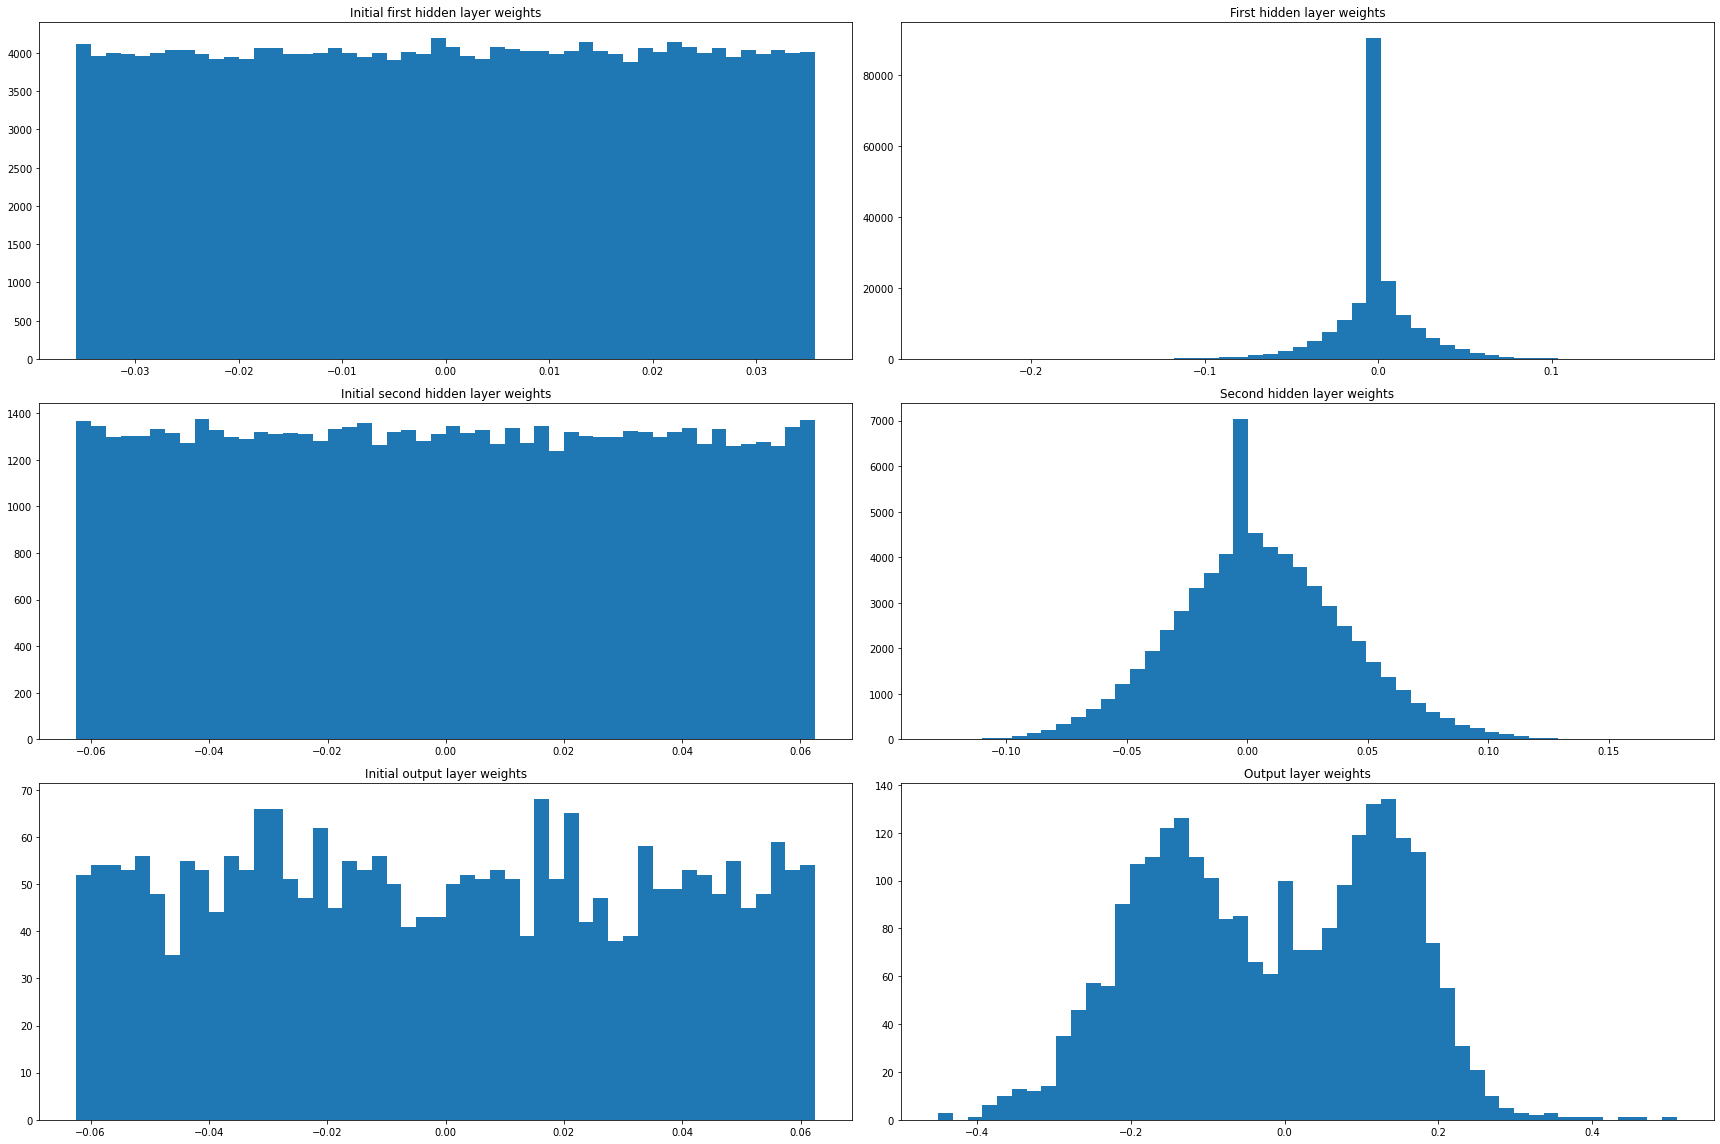

In [31]:
# Weights histogram
fig, axs = plt.subplots(3, 2, figsize=(24,16))
axs[0,0].hist(initial_h1_w.flatten(), 50)
axs[0,0].set_title('Initial first hidden layer weights')
axs[1,0].hist(initial_h2_w.flatten(), 50)
axs[1,0].set_title('Initial second hidden layer weights')
axs[2,0].hist(initial_out_w.flatten(), 50)
axs[2,0].set_title('Initial output layer weights')
#[ax.grid() for ax in axs]
axs[0,1].hist(h1_w.flatten(), 50)
axs[0,1].set_title('First hidden layer weights')
axs[1,1].hist(h2_w.flatten(), 50)
axs[1,1].set_title('Second hidden layer weights')
axs[2,1].hist(out_w.flatten(), 50)
axs[2,1].set_title('Output layer weights')
plt.tight_layout()
plt.show()

### Analyze activations

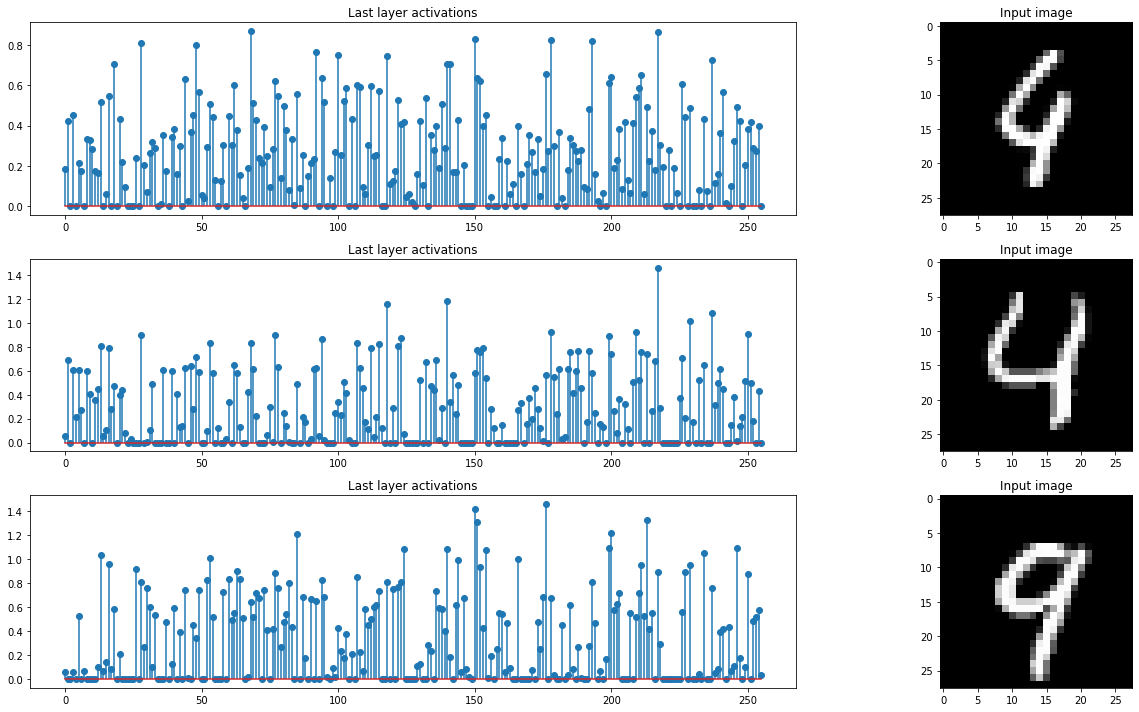

In [32]:
def get_activation(layer, input, output):
    global activation
    act = nn.ReLU6()
    activation = act(output)

### Register hook  
hook_handle = net.fc2.register_forward_hook(get_activation)

### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = test_dataset[115][0].to(device)
    y1 = net(x1)
    z1 = activation
    z1 = np.squeeze(z1,0)
    x2 = test_dataset[4][0].to(device)
    y2 = net(x2)
    z2 = activation
    z2 = np.squeeze(z2,0)
    x3 = test_dataset[12][0].to(device)
    y3 = net(x3)
    z3 = activation
    z3 = np.squeeze(z3,0)


### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 2, figsize=(20,10))
axs[0,0].stem(z1.cpu().numpy(), use_line_collection=True)
axs[0,0].set_title('Last layer activations' )
axs[1,0].stem(z2.cpu().numpy(), use_line_collection=True)
axs[1,0].set_title('Last layer activations' )
axs[2,0].stem(z3.cpu().numpy(), use_line_collection=True)
axs[2,0].set_title('Last layer activations' )
axs[0,1].imshow(x1.cpu().squeeze().numpy(), cmap='gist_gray')
axs[0,1].set_title('Input image')
axs[1,1].imshow(x2.cpu().squeeze().numpy(), cmap='gist_gray')
axs[1,1].set_title('Input image')
axs[2,1].imshow(x3.cpu().squeeze().numpy(), cmap='gist_gray')
axs[2,1].set_title('Input image' )
plt.tight_layout()
plt.show()

### Bidimensional space visualization

In [33]:
def hook_feature_space(module, input, output):
    feature_space.append(output) # feature_space must be a list defined before evaluating the network output

# Attach the hook function to layer classifier[5]
hook_handle = net.fc2.register_forward_hook(hook_feature_space)

In [34]:
feature_space = [] # This list will be filled by the feature space values

### Analyze all the test samples
test_outputs, test_labels, test_loss = test_epoch(
    net=net,
    device=device, 
    dataloader=test_dataloader, 
    loss_fn=loss_fn)

# Concatenate all the features in a single tensor
feature_space = torch.cat(feature_space)

In [35]:
feature_space = feature_space.cpu()
test_labels   = test_labels.cpu()
test_outputs  = test_outputs.cpu()

In [36]:
### t-SNE embedding of the dataset (t-distributed Stochastic Neighbor Embedding)
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
feature_space_tsne = tsne.fit_transform(feature_space)

Computing t-SNE embedding


In [37]:
df = pd.DataFrame(feature_space_tsne)
df['label'] = test_labels


In [38]:
import plotly.express as px 
px.scatter(df, x=0, y=1, color='label', hover_data=[df.index])

# Convolutional Neural Network

## Network definition

In [39]:
class CNN(nn.Module):
   def __init__(self, num_classes):
        super().__init__()
        
        # 28x28x1  28x28x16
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=16,
                                      kernel_size=5,
                                      stride=1,
                                      padding=2) 
        # 28x28x16  14x14x16
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=2,
                                         stride=2,
                                         padding=0) 

        self.norm_1 = torch.nn.BatchNorm2d(16)

        # 14x14x16  14x14x32
        self.conv_2 = torch.nn.Conv2d(in_channels=16,
                                      out_channels=32,
                                      kernel_size=5,
                                      stride=1,
                                      padding=2) # (1(14-1) - 14 + 3) / 2 = 1                 
        # 14x14x32  7x7x32                            
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=0) # (2(7-1) - 14 + 2) = 0

        self.norm_2 = torch.nn.BatchNorm2d(32)

        
        self.linear_1 = torch.nn.Linear(7*7*32, num_classes)
        self.act = nn.ReLU()
        self.flatten = nn.Flatten(start_dim=1)
        self.dropout = nn.Dropout(0.3)

   def forward(self, x):
        x = self.act(self.conv_1(x))
        x = self.pool_1(x)
        x = self.dropout(x)
        #x = self.norm_1(x)
        x = self.act(self.conv_2(x))
        x = self.pool_2(x)
        x = self.dropout(x)
        #x = self.norm_2(x)
        x = self.flatten(x)
        x = self.linear_1(x)
        return x


## Initialization

In [40]:
# network
torch.manual_seed(0)
num_classes = 10
net = CNN(num_classes)
net = net.to(device)

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
learning_rate = 0.001
weight=0
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,weight_decay=weight)

## Training loop

In [41]:
num_epochs = 30

train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
  print('#################')
  print(f'# EPOCH {epoch_num}')
  print('#################')

  train_loss = train_epoch(net, device, train_dataloader, loss_fn, optimizer)  
  print(f"AVERAGE TRAIN LOSS: {train_loss}")
  train_loss_log.append(train_loss)
  
  ### VALIDATION
  _,_,val_loss = test_epoch(net, device, val_dataloader, loss_fn)  
  print(f"AVERAGE VAL LOSS: {(val_loss)}")
  val_loss_log.append(val_loss)


 

#################
# EPOCH 0
#################
AVERAGE TRAIN LOSS: 0.26442819833755493
AVERAGE VAL LOSS: 0.09416813403367996
#################
# EPOCH 1
#################
AVERAGE TRAIN LOSS: 0.0879041999578476
AVERAGE VAL LOSS: 0.06078091263771057
#################
# EPOCH 2
#################
AVERAGE TRAIN LOSS: 0.06583662331104279
AVERAGE VAL LOSS: 0.05088519677519798
#################
# EPOCH 3
#################
AVERAGE TRAIN LOSS: 0.05560899153351784
AVERAGE VAL LOSS: 0.04385676980018616
#################
# EPOCH 4
#################
AVERAGE TRAIN LOSS: 0.04825352132320404
AVERAGE VAL LOSS: 0.041595034301280975
#################
# EPOCH 5
#################
AVERAGE TRAIN LOSS: 0.04327310621738434
AVERAGE VAL LOSS: 0.04037541523575783
#################
# EPOCH 6
#################
AVERAGE TRAIN LOSS: 0.041054241359233856
AVERAGE VAL LOSS: 0.044361282140016556
#################
# EPOCH 7
#################
AVERAGE TRAIN LOSS: 0.03659484535455704
AVERAGE VAL LOSS: 0.03892548754811287
######

## Result analysis

### Test loss

In [42]:
test_outputs, test_labels, test_loss = test_epoch(
    net=net,
    device=device, 
    dataloader=test_dataloader, 
    loss_fn=loss_fn)
# Print Test loss
print(f"\n\nTEST LOSS : {test_loss}")



TEST LOSS : 0.024008383974432945


### Confusion matrix

In [43]:
# Predicted labels
y_true = test_labels.cpu().data.numpy()
y_pred = test_outputs.cpu().argmax(dim=1).numpy()
# Evaluate confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)
# Show the confusion matrix
pd.DataFrame(cm)

,0,1,2,3,4,5,6,7,8,9
0,977,0,0,1,0,0,1,0,1,0
1,0,1132,1,1,0,0,1,0,0,0
2,1,0,1029,0,0,0,0,2,0,0
3,0,0,0,1004,0,4,0,0,2,0
4,0,0,0,0,971,0,1,0,1,9
5,1,0,0,3,0,886,1,0,0,1
6,2,2,1,0,1,2,947,0,3,0
7,0,2,1,1,0,1,0,1018,1,4
8,2,0,2,1,0,1,0,0,965,3
9,0,0,0,0,3,3,0,2,0,1001


### Accuracy

In [44]:
accuracy=100*sum(np.diag(cm))/len(y_true)
print("TEST ACCURACY: ",accuracy,"%")

TEST ACCURACY:  99.3 %


### Analyze Softmax network output

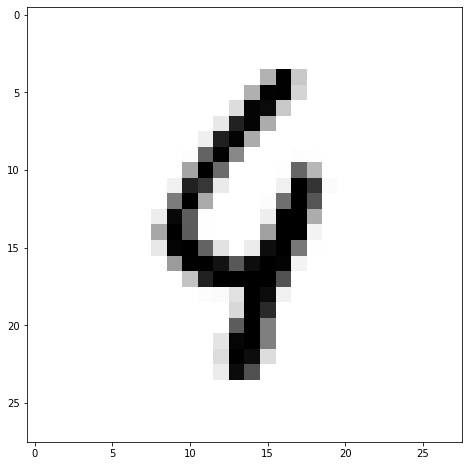

In [45]:
index = 115
image, label = test_dataset[index]
fig = plt.figure(figsize=(8,8))
image  = torch.squeeze(image,0)
plt.imshow(image, cmap='Greys')
image_tensor = image.to(device)

In [46]:
net.eval()
with torch.no_grad(): # Disable gradient tracking
    out = net(image_tensor.unsqueeze(0).unsqueeze(0))
prob = nn.functional.softmax(out, dim=1)
prob = prob.flatten().cpu().numpy()
fig = px.bar(y=prob)
fig.update_layout(xaxis_title='Class Index', yaxis_title='Softmax Network Output')

### Analyze network weight

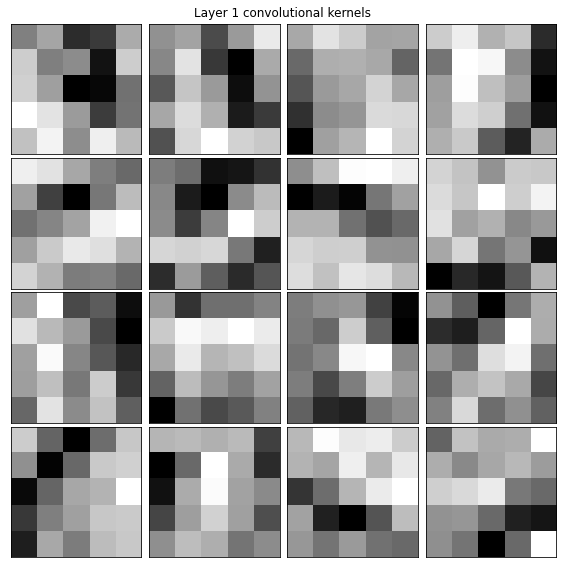

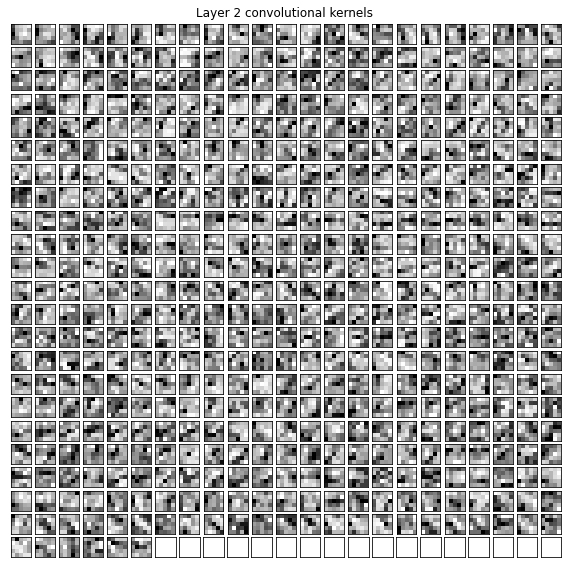

In [47]:
## Extract weights 
# Layer 1 weights
weights_l1 = net.conv_1.weight.data.cpu().numpy()
# Layer 2 weights
weights_l2 = net.conv_2.weight.data.cpu().numpy()

### Plot the weights (this is a utility function, no need to analyze this code)
def plot_nchw_data(data, h_num, v_num, title):
    fig, axs = plt.subplots(h_num, v_num, figsize=(8,8))
    shape = data.shape
    data = data.reshape(shape[0]*shape[1], shape[2], shape[3])
    for idx, ax in enumerate(axs.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        if idx < len(data):
            ax.imshow(data[idx,:,:], cmap='gray')
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 0.97], h_pad=0, w_pad=0)
    plt.show()

plot_nchw_data(weights_l1, 4, 4, 'Layer 1 convolutional kernels')
plot_nchw_data(weights_l2, 23, 23, 'Layer 2 convolutional kernels')


### Analyze the activations for a single input image

In [48]:
# Hook function to call during forward pass
def hook_fn(module, input, output):
    intermediate_outputs.append(output)

# Attach hook function to all the convolutional layers
hook_handles = [] # This list will contains all the handles required to remove the hooks later
hook_handles.append(net.conv_1.register_forward_hook(hook_fn))
hook_handles.append(net.conv_2.register_forward_hook(hook_fn))

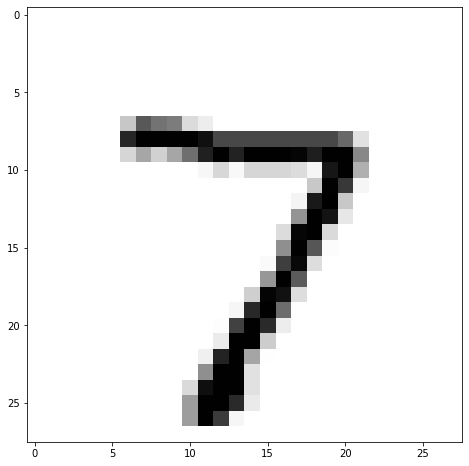

In [49]:
# show image
sample_index = 0
image = test_dataset[sample_index][0]
fig = plt.figure(figsize=(8,8))
plt.imshow(image.squeeze().numpy(), cmap='Greys')

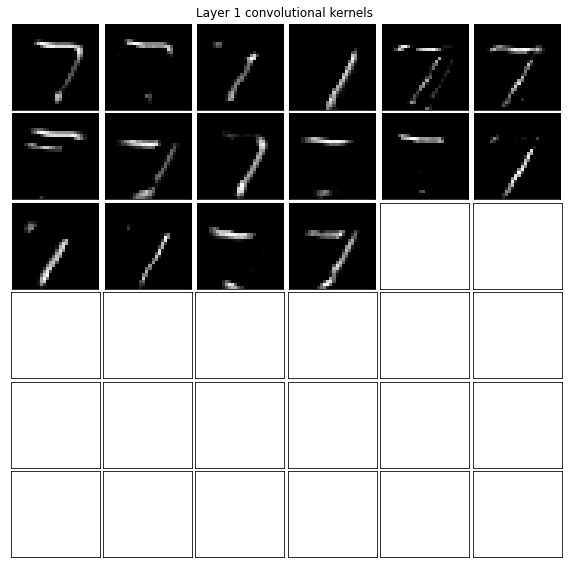

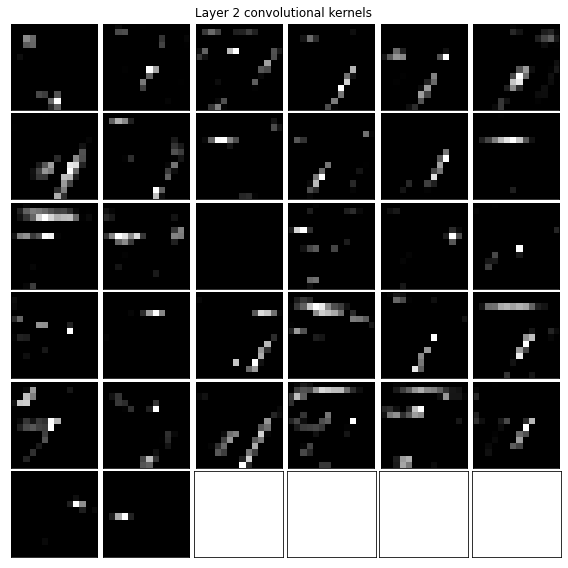

In [50]:
# Evaluate output
net.eval()
with torch.no_grad():
    intermediate_outputs = []
    out = net(image.unsqueeze(0).to(device))
    # Now the intermediate_outputs list contains the intermediate outputs thanks to the hook function

# Analyze intermediate outputs
for layer_num, intermediate_output in enumerate(intermediate_outputs):
    intermediate_output = nn.functional.relu(intermediate_output).cpu().data.numpy()
    # Plot
    plot_nchw_data(intermediate_output, 6, 6, 'Layer %d convolutional kernels' % (layer_num + 1))
